In [ ]:
pip install insightface

In [ ]:
pip install onnxruntime

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd

import insightface
import onnxruntime
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
from insightface.model_zoo import get_model


 Initialize the FaceAnalysis application with the 'buffalo_l' model and prepare it for use
 This setup uses GPU (ctx_id=0) and sets the detection size to 640x640 pixels

In [ ]:
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

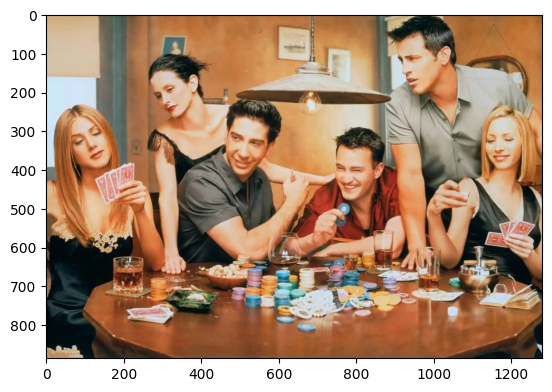

In [ ]:
img = ins_get_image('t1')
plt.imshow(img[:, :, ::-1])
plt.show()

In [ ]:
faces = app.get(img)

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


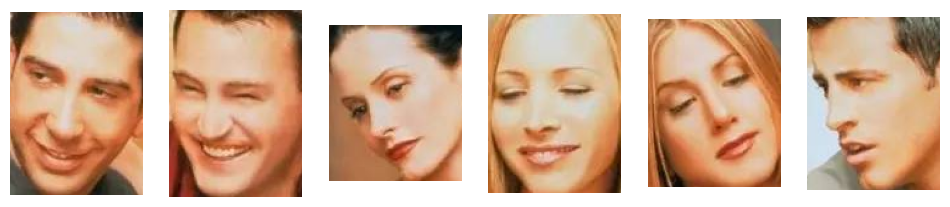

In [ ]:
img = ins_get_image('t1')
fig, axs = plt.subplots(1, len(faces), figsize=(12, 5))

for i ,face in enumerate(faces):
    bbox = face['bbox']
    bbox = [int(i) for i in bbox]
    axs[i].imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
    axs[i].axis('off')

# downloading the model from link


In [ ]:
!wget https://huggingface.co/CountFloyd/deepfake/resolve/main/inswapper_128.onnx -O inswapper_128.onnx

--2024-06-01 15:11:09--  https://huggingface.co/CountFloyd/deepfake/resolve/main/inswapper_128.onnx
Resolving huggingface.co (huggingface.co)... 18.238.109.52, 18.238.109.92, 18.238.109.102, ...
Connecting to huggingface.co (huggingface.co)|18.238.109.52|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/f7/d7/f7d7d940dac099fff8d8e8a39c964e80ea9a852a5d0f4926ef9d25d2dda69273/e4a3f08c753cb72d04e10aa0f7dbe3deebbf39567d4ead6dce08e98aa49e16af?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27inswapper_128.onnx%3B+filename%3D%22inswapper_128.onnx%22%3B&Expires=1717513869&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNzUxMzg2OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mNy9kNy9mN2Q3ZDk0MGRhYzA5OWZmZjhkOGU4YTM5Yzk2NGU4MGVhOWE4NTJhNWQwZjQ5MjZlZjlkMjVkMmRkYTY5MjczL2U0YTNmMDhjNzUzY2I3MmQwNGUxMGFhMGY3ZGJlM2RlZWJiZjM5NTY3ZDRlYWQ2ZGNlMDhlOThhYTQ5ZTE2

In [ ]:
!md5sum inswapper_128.onnx

a3a155b90354160350efd66fed6b3d80  inswapper_128.onnx


# load the downloaded model

In [ ]:
swapper = insightface.model_zoo.get_model('inswapper_128.onnx',
                                          )

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
inswapper-shape: [1, 3, 128, 128]


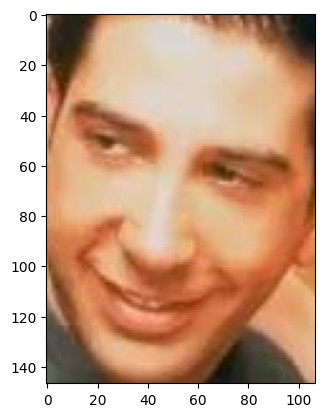

In [ ]:
source_face = faces[0]
bbox = source_face['bbox']
bbox = [int(i) for i in bbox]
plt.imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
plt.show()

In [ ]:
res = img.copy()
for face in faces:
    res = swapper.get(res, face, source_face, paste_back=True)

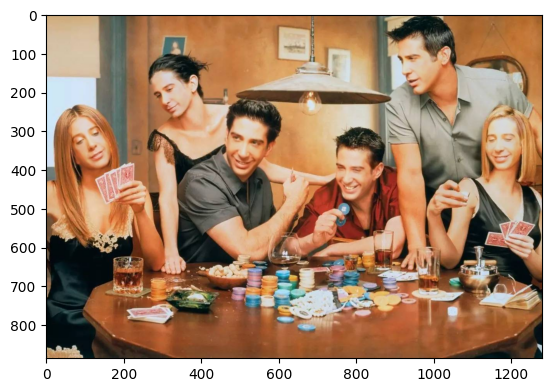

In [ ]:
plt.imshow(res[:,:,::-1])
plt.show()

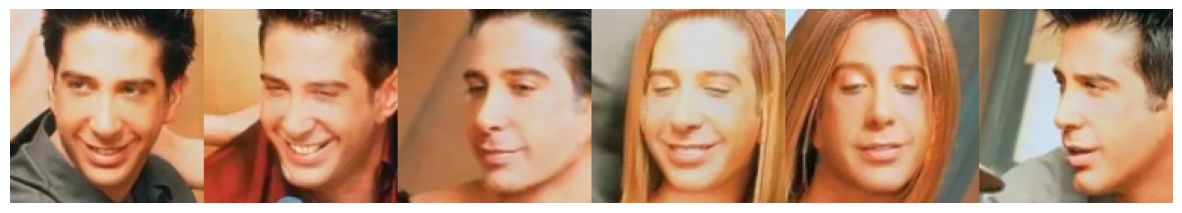

In [ ]:
res = []
for face in faces:
  _img, _ = swapper.get(img, face, source_face, paste_back=False)
  res.append(_img)
res = np.concatenate(res, axis=1)
fig, axs = plt.subplots(figsize=(15, 5))
axs.imshow(res[:,:,::-1])
axs.axis('off')
plt.show()

#Swap in my face


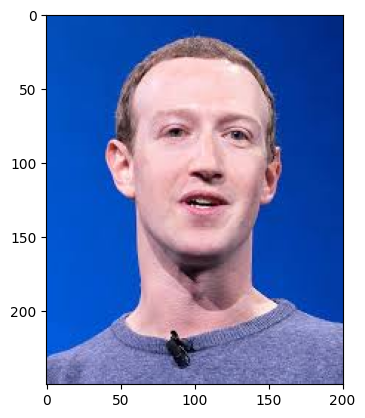

In [ ]:
rob = cv2.imread('rob.png')
plt.imshow(rob[:,:,::-1])
plt.show()

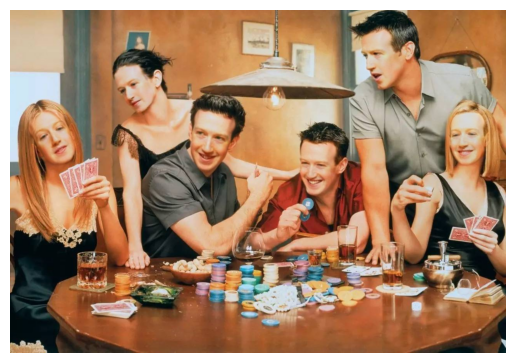

In [ ]:
#Detect the face
rob_faces = app.get(rob)
rob_face = rob_faces[0]
# Replace faces in friends image
res = img.copy()
for face in faces:
    res = swapper.get(res, face, rob_face, paste_back=True)

fig, ax = plt.subplots()
plt.imshow(res[:,:,::-1])
ax.axis('off')
plt.show()

In [ ]:
res = []
for face in faces:
  _img, _ = swapper.get(img, face, source_face, paste_back=False)
  res.append(_img)
res = np.concatenate(res, axis=1)
fig, axs = plt.subplots(figsize=(15, 5))
axs.imshow(res[:,:,::-1])
axs.axis('off')
plt.show()

# Uses face swapper to Swap faces in an different images.

In [ ]:
def swap_face(img1_fn, img2_fn, app, swapper, plot_before=True, Plot_after=True):
  """
  Uses face swapper to Swap faces in an different images.

  plot_before: if True shows the images before the swap
  Plot_after: if True shows the images after the swap

  reture images with swapped faces.
  Assumes one face per image.
  """

  img1 = cv2.imread(img1_fn)
  img2 = cv2.imread(img2_fn)

  if plot_before:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1[:,:,::-1])
    axs[0].axis('off')
    axs[1].imshow(img2[:,:,::-1])
    axs[1].axis('off')
    plt.show()

  faces1 = app.get(img1)[0]
  faces2 = app.get(img2)[0]

  img1_ = img1.copy()
  img2_ = img2.copy()
  if Plot_after:
    img1_ = swapper.get(img1_, faces1, faces2, paste_back=True)
    img2_ = swapper.get(img2_, faces2, faces1, paste_back=True)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1_[:,:,::-1])
    axs[0].axis('off')
    axs[1].imshow(img2_[:,:,::-1])
    axs[1].axis('off')
    plt.show()

  return img1_, img2_

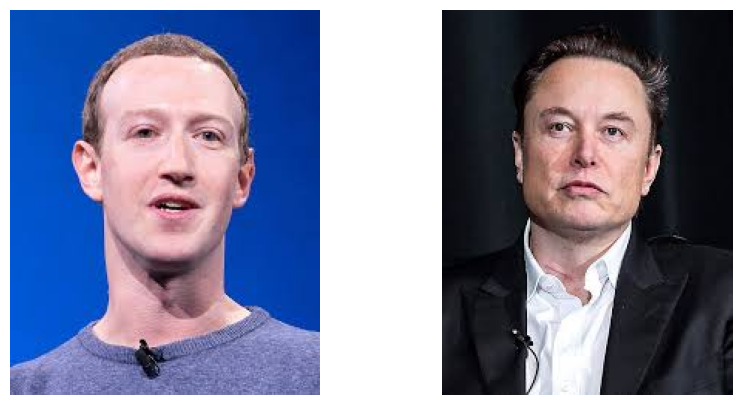

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


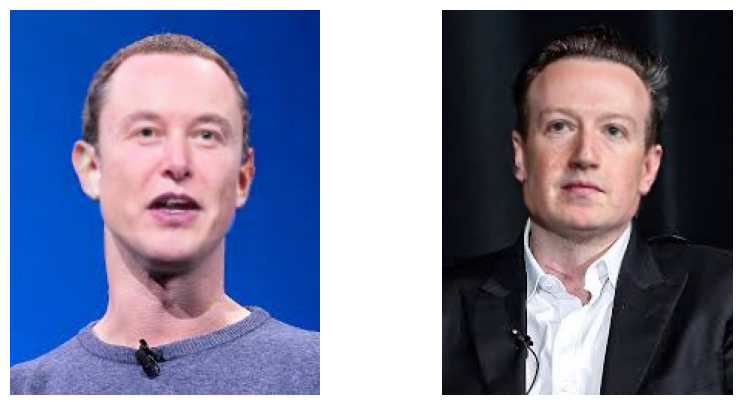

In [ ]:
_ = swap_face('rob.png', 'mask.png', app, swapper)

# Uses face swapper to swap faces in the same image.

In [ ]:
def swap_face_from_same_img(img1_fn, app, swapper, plot_before=True, plot_after=True):
    """
    Uses face swapper to swap faces in the same image.

    img1_fn: path to the input image
    app: face detection and alignment application
    swapper: face swapping tool
    plot_before: if True, shows the image before the swap
    plot_after: if True, shows the image after the swap

    Returns: image with swapped faces
    Assumes one face per image.
    """

    # Read the image
    img1 = cv2.imread(img1_fn)

    # Display the image before swapping if requested
    if plot_before:
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Before Swapping')
        plt.show()

    # Detect faces in the image
    faces = app.get(img1)

    if len(faces) != 2:
        raise ValueError("The image should contain exactly two faces for swapping.")

    # Swap faces
    face1_swapped = swapper.get(img1, faces[0], faces[1], paste_back=True)
    face2_swapped = swapper.get(img1, faces[1], faces[0], paste_back=True)

    img_swapped = np.concatenate([face1_swapped, face2_swapped], axis=1)

    # Display the image after swapping if requested
    if plot_after:
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img_swapped, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('After Swapping')
        plt.show()

    return img_swapped

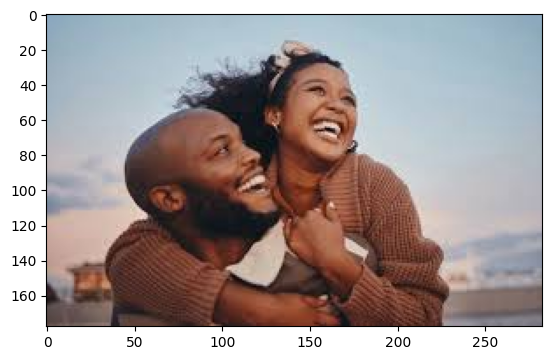

In [ ]:
couples = cv2.imread('couples.jpeg')
plt.imshow(couples[:,:,::-1])
plt.show()

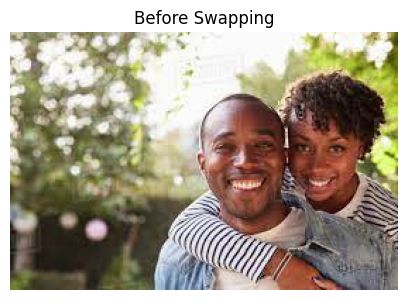

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


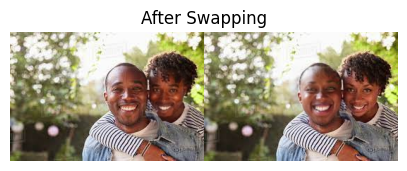

In [ ]:
_ = swap_face_from_same_img('images.jpeg', app, swapper) # Pass the file path instead of the image data